## Optiver Competition (Version 7)

Overview: I will attempt to connect all models in the following manner.
Setup 3 will predict using the features whether or not the target is in the tails of distribution or not (either 5% < target < 95% or (target < 5% or target > 95%)
If Setup 3 Predicts the target to be in the tail of distribution:
    - Use Setup 1 to predict the price change prediction
If Setup 3 Predicts the target to not be in the tail of the distribution:
    - Use Setup 2 to predict the price change prediction

**IMPORTANT NOTE:** **SINCE THE OUTLIER LOOKS TO BE STILL CENTERED AROUND ZERO. I WILL BEGIN WITH THE OPTIMIZED THRESHOLD FOR WHICH MODELTO USE IN SETUP 3. IF THIS PROVES TO BE HORRILY INEFFICIENT THEN I WILL USE A MUCH HIGHER THRESHOLD, MAKING SURE THAT MOST OF THE PREDICTIONS COME FROM SETUP 1. MY IDEA IS SINCE SETUP 2'S PREDICTIONS EVEN ON OUTLIERS STILL SEEM TO BE CENTERED AROUND THE MEAN, I MIGHT BE ABLE TO GIVE IT AS MANY TRUE OUTLIERS AS POSSIBLE AND IF THERE ARE A FEW NON OUTLIERS THAT WORK ITS WAY INTO THE MODEL IT WILL BE OK.**


**Plan (5% < target < 95%):**
1. Put the pieces together, do error analysis, submit if better score



**Further Ideas:**
Refer to your written error logs for the next steps:
- Optimize every model again as you changed the training data. Leave large/small data splitting the same. Compare final model ensemble with full test set MAE. This should give you an apple to apples comparison of error to see if this new ensemble performs better
- Split the data being outliers tails width 1%, rerun, note results, optimize, note results.
- Whichever of these perform better is how you will split the data

## Current Features / Data Splitting
- These are the features I had gotten from the newer notebook
- I separate the data into 'large' 5% < target < 95% and 'small' (in the tails)

In [1]:
import pandas as pd
import numpy as np
import catboost as cbt
import lightgbm as lgb
import gc
from itertools import combinations
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from warnings import simplefilter
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import yeojohnson
#Filtering some warnings (we might wanna look at the performance one maybe)
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


#Read data, calculate median, std_deviation of total bid + sizes, get target
train = pd.read_csv('train.csv')
median_sizes = train.groupby('stock_id')['bid_size'].median() + train.groupby('stock_id')['ask_size'].median()
std_sizes = train.groupby('stock_id')['bid_size'].std() + train.groupby('stock_id')['ask_size'].std()
train = train.dropna(subset=['target'])


#The author's feature engineering. Could work well we could potentially improve and combine from last notebook if there are any differences
def feat_eng(df):
    
    cols = [c for c in df.columns if c not in ['row_id', 'time_id']]
    df = df[cols]
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
    df['bid_ask_volume_diff'] = df['ask_size'] - df['bid_size']
    df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['bid_plus_ask_sizes'] = df['bid_size'] + df['ask_size']
    df['median_size'] = df['stock_id'].map(median_sizes.to_dict())
    df['std_size'] = df['stock_id'].map(std_sizes.to_dict())
    df['high_volume'] = np.where(df['bid_plus_ask_sizes'] > df['median_size'], 1, 0)
        
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

    #Changed this part because it didn't handle zero cases
    # This part should handle null values and avoid data loss
    for c in combinations(prices, 2):
        df[f'{c[0]}_minus_{c[1]}'] = (df[f'{c[0]}'] - df[f'{c[1]}']).astype(np.float32)
        denominator = df[f'{c[0]}'] + df[f'{c[1]}']
        df[f'{c[0]}_{c[1]}_imb'] = np.where(denominator != 0, (df[f'{c[0]}'] - df[f'{c[1]}']) / denominator, 0).astype(np.float32)
    
    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_
        denominator = mid_ - min_
        df[f'{c[0]}_{c[1]}_{c[2]}_imb2'] = np.where(denominator != 0, (max_ - mid_) / denominator, 0).astype(np.float32)
    df.drop(columns=['date_id',], inplace=True)
    gc.collect()
    
    print('Features Finished Calculating')
    return df


# Note the X, y columns
X = feat_eng(train.drop(columns='target'))
y = train['target'].values

# Remove rows with missing target values
valid_indices = np.isfinite(y)
X = X[valid_indices]
y = y[valid_indices]

# Calculate the lower and upper percentiles
lower_threshold = np.percentile(y, 5)
upper_threshold = np.percentile(y, 95)

# Get indices for both tails
indices_lower = np.where(y < lower_threshold)[0]
indices_upper = np.where(y > upper_threshold)[0]

# Combine indices from both tails for the small dataset
indices_small = np.concatenate([indices_lower, indices_upper])

# For the large dataset, exclude indices from both tails
indices_large = np.setdiff1d(np.arange(len(y)), indices_small)

# Create the subsets
X_small, y_small = X.iloc[indices_small], y[indices_small]
X_large, y_large = X.iloc[indices_large], y[indices_large]

#--------------------------------------------------------------------------------------------------------------

# Train-test split for the large set
X_train_large, X_temp_large, Y_train_large, Y_temp_large = train_test_split(X_large, y_large, test_size=0.2, random_state=42)
X_val_large, X_test_large, Y_val_large, Y_test_large = train_test_split(X_temp_large, Y_temp_large, test_size=0.5, random_state=42)

# Train-test split for the small set
X_train_small, X_temp_small, Y_train_small, Y_temp_small = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
X_val_small, X_test_small, Y_val_small, Y_test_small = train_test_split(X_temp_small, Y_temp_small, test_size=0.5, random_state=42)

# Save indices
train_index_large = np.arange(len(X_train_large))
val_index_large = np.arange(len(X_val_large))
train_index_small = np.arange(len(X_train_small))
val_index_small = np.arange(len(X_val_small)) 

#Save the bounds of the target
y_min = np.min(y)
y_max = np.max(y)

Features Finished Calculating


## 1. Function Creation
- I will create a training, error analysis, and plotting function

In [2]:
#Having this return the list of fitted models. Need to input model_dict (see later in here) 
def train_models_with_cv(model_dict, X_train, Y_train, X_val, Y_val, modelname='LGBMRegressor', model_path='', is_train=True):
    if is_train:
        train_index = np.arange(len(X_train))
        val_index = np.arange(len(X_val))
        X_train_fold = X_train[train_index%n_folds!=i]
        Y_train_fold = Y_train[train_index%n_folds!=i]
        X_val_fold = X_val[val_index%n_folds==i]
        Y_val_fold = Y_val[val_index%n_folds==i]
        
        model = model_dict[modelname]

        if modelname == 'LGBMRegressor':
            callbacks = [lgb.callback.early_stopping(25, first_metric_only=True, verbose=True, min_delta=.01)]
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], eval_metric='mae', callbacks=callbacks) 

        if modelname == 'CatBoostRegressor':
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], verbose=1, early_stopping_rounds=25)

        if modelname == 'CatBoostClassifier':
            model.fit(X_train_fold, Y_train_fold, eval_set=[(X_val_fold, Y_val_fold)], early_stopping_rounds=25)
            
        #Append the best iteration of a model and save
        
        joblib.dump(model, f'{model_path}/{modelname}_{i}.model')
        return model
    else:
        model = joblib.load(f'{model_path}/{modelname}_{i}.model')
        print(f'{modelname}_{i} loaded')
        return model

    

In [29]:
#Transformation function from author 
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices)/np.sum(std_error)
    out = prices-std_error*step
    return out
    
#You need to feed the model dictionary (so it knows which one its using) and the actual fitted models
def calculate_mae(model_dict, models, X_test, Y_test):  
    # Initialize lists to store MAE for each model and predictions
    mae_scores = {model_name: [] for model_name in model_dict}
    all_predictions = []
    
    # Save the indices of the test set
    test_index = np.arange(len(X_test))

    #Iterate through models and folds to calculate error
    for model_name in model_dict: # Iterate through the three models
        for fold in range(n_folds): #Iterate through all the folds
            # Initialize lists to store predictions for each model
            model_predictions = {model_name: [] for model_name in model_dict}
            #Calculate the test folds
            X_test_fold = X_test[test_index%n_folds!=fold]
            Y_test_fold = Y_test[test_index%n_folds!=fold]
            for model in models: # Idea is to iterate through the models and for each fold and predict on it and save it
                if model_name == model.__class__.__name__:
                    y_pred_test = model.predict(X_test_fold)  # Predict using the test data for this fold
                    mae = mean_absolute_error(Y_test_fold, y_pred_test)  # Calculate MAE for this fold
                    mae_scores[model_name].append(mae)
                    model_predictions[model_name] = y_pred_test
                    #print(f'{model_name} MAE Calculated for fold {fold + 1}')
    
    # Calculate the average MAE for each model
    average_mae_scores = {model_name: np.mean(scores) for model_name, scores in mae_scores.items()}
    
    # Calculate averaged predictions for all models
    all_model_prediction = np.mean([model.predict(X_test) for model in models], 0)
    print(f'Averaged Prediction MAE: {mean_absolute_error(Y_test, all_model_prediction)}')
    
    # Perform zero sum transformation
    zero_summed_prediction = zero_sum(all_model_prediction, X_test['bid_size'] + X_test['ask_size'])
    print(f'Averaged and Zero Summed Prediction MAE: {mean_absolute_error(Y_test, zero_summed_prediction)}')
    
    #Get the clipped prediction by clipping THIS IS LIKE THE LAST ONE THEN WE WILL CHECK HOW CLOSE IT IS TO TARGET
    final_transformed_prediction = np.clip(all_model_prediction, y_min, y_max)
    
    #Calculate the MAE for this averaged prediction
    final_transformed_prediction_mae = mean_absolute_error(Y_test, final_transformed_prediction)
    
    # Print the results
    for model_name, score in average_mae_scores.items():
        print(f"{model_name} - {n_folds} fold MAE: {score}")
    
    print(f"Averaged, Zero Summed, and Clipped Final Transformed Prediction MAE : {final_transformed_prediction_mae}")

In [3]:
#Title Addition
def test_scatterplot(models, X_test, Y_test, title):
    # Initialize a dictionary to store the predictions for each model
    predictions_by_model = {}
    
    # Get predictions for each model
    for model in models:
        model_name = model.__class__.__name__
        y_pred_test = model.predict(X_test)
        predictions_by_model[model_name] = y_pred_test
    
    # Create a scatter plot for all models
    plt.figure(figsize=(8, 8))
    
    for model_name, y_pred_test in predictions_by_model.items():
        plt.scatter(Y_test, y_pred_test, alpha=0.5, label=model_name)
    
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='red', label='y=x line')
    
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    
    plt.show()

## 2. Error Analysis
- I will train all of the models I have from Setup 1, 2, 3 using the optimized parameters I found with the current splitting of the target
- Note that as soon as I change the 'small' and 'large' dataset I will have to reoptimize

### Model Setup 3 (Optimized): Training a decision tree, to decide which 'model setup' to use:
- Note Setup 3 trains on the ENTIRE Dataset

In [4]:
# Note the X, y columns
X = feat_eng(train.drop(columns='target'))
y = train['target'].values

#Create threshold of distribution
lower_threshold = np.percentile(y, 5)
upper_threshold = np.percentile(y, 95)

# Remove rows with missing target values
valid_indices = np.isfinite(y)
X = X[valid_indices]
y = y[valid_indices]

#--------------------------------------------------------------------------------------------------
# Create a binary target: 1 if in the tail, 0 otherwise
y_binary = np.where((y <= lower_threshold) | (y >= upper_threshold), 1, 0)
#--------------------------------------------------------------------------------------------------

# Split the data into training and test
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Save indices
train_index = np.arange(len(X_train))
val_index = np.arange(len(X_val))

# Setup the Benchmark Target Classification Model
params_cbt = {
    'iterations': 500,
    'learning_rate': 0.2,
    'depth': 5,
    'l2_leaf_reg': 12,
    'loss_function': 'Logloss',
    'verbose': 10
}

# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup3 = {
    'CatBoostClassifier': cbt.CatBoostClassifier(**params_cbt),
}

#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup3 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup3"

# Initilaize where I will store all final setup 3 models
trained_setup3_models = []

print('Begin Training/Loading of Setup 3 Models (Optimized)')
for i in range(n_folds):
    trained_setup3_models.append(train_models_with_cv(model_dict_setup3, X_train, Y_train, X_val, Y_val, modelname='CatBoostClassifier', model_path=model_path_setup3, is_train=True))


Features Finished Calculating
Begin Training/Loading of Setup 3 Models (Optimized)
0:	learn: 0.5212109	test: 0.5210698	best: 0.5210698 (0)	total: 316ms	remaining: 2m 37s
10:	learn: 0.2927371	test: 0.2930471	best: 0.2930471 (10)	total: 2.06s	remaining: 1m 31s
20:	learn: 0.2861443	test: 0.2869474	best: 0.2869474 (20)	total: 3.81s	remaining: 1m 26s
30:	learn: 0.2839158	test: 0.2850216	best: 0.2850216 (30)	total: 5.59s	remaining: 1m 24s
40:	learn: 0.2823161	test: 0.2835978	best: 0.2835978 (40)	total: 7.39s	remaining: 1m 22s
50:	learn: 0.2811170	test: 0.2825031	best: 0.2825031 (50)	total: 9.25s	remaining: 1m 21s
60:	learn: 0.2805319	test: 0.2820182	best: 0.2820182 (60)	total: 11.1s	remaining: 1m 19s
70:	learn: 0.2799255	test: 0.2814825	best: 0.2814825 (70)	total: 12.8s	remaining: 1m 17s
80:	learn: 0.2792899	test: 0.2809208	best: 0.2809208 (80)	total: 14.5s	remaining: 1m 15s
90:	learn: 0.2787516	test: 0.2804041	best: 0.2804041 (90)	total: 16.3s	remaining: 1m 13s
100:	learn: 0.2780987	test: 0

### Model Setup 1 (Optimized) {5 < target < 95 (percentile)}

In [5]:
# CBT Parameters (Optimized)
params_cbt = {
    'objective': 'MAE',
    'learning_rate': .15,
    'l2_leaf_reg': 1,
    'iterations': 500,
    'depth': 9,
    'use_best_model': True,
}

# LGBM Parameters (Optimized)
params_lgb = {
    'learning_rate': 0.2,
    'max_depth': 10,
    'n_estimators': 500,
    'num_leaves': 300,
    'objective': 'mae',
    'random_state': 42,
  #  'reg_alpha': 0.01,        leaving out for now
  #  'reg_lambda': 0.01,       leaving out for now
    'n_jobs': -1,
    'early_stopping_rounds': 100,
    'verbose': 2,
    'subsample_for_bin': 250000,
    'min_split_gain': .15,
    'min_child_weight': 1
}

#Had to change names for full so i can analyze on test set its weird its for the model.__name__ part
# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup1 = {
    'CatBoostRegressor': cbt.CatBoostRegressor(**params_cbt),
    'LGBMRegressor': lgb.LGBMRegressor(**params_lgb)
}

#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup1 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup1"

# Initilaize where I will store all final setup 1 models
trained_setup1_models = []


print('Begin Training/Loading of Setup 1 Models (Optimized)')
for i in range(n_folds):
    trained_setup1_models.append(train_models_with_cv(model_dict_setup1, X_train_large, Y_train_large, X_val_large, Y_val_large, modelname='LGBMRegressor', model_path=model_path_setup1, is_train=True))
    trained_setup1_models.append(train_models_with_cv(model_dict_setup1, X_train_large, Y_train_large, X_val_large, Y_val_large, modelname='CatBoostRegressor', model_path=model_path_setup1, is_train=True))


Begin Training/Loading of Setup 1 Models (Optimized)
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.075683
[LightGBM] [Debug] init for col-wise cost 0.000185 seconds, init for row-wise cost 0.191726 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16969
[LightGBM] [Info] Number of data points in the train set: 2514440, number of used features: 70
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Debug] Trained a tree with leaves = 300 and depth = 10
Training until validation scores don't improve for 25 rounds
Training until validat

### Model Setup 2 (Optimized) (target < 5% or target > 95%)

In [6]:
# Initialize the LightGBM regressor (Optimized)
lgbm_setup2_params = {
    #'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'num_leaves': 300,  # Use maximum number for 8-depth tree
    'learning_rate': 0.2,   # A smaller learning rate
    'n_estimators': 500,    # More trees
    'max_depth': 10,          # Allowing deep trees
    'sub_sample_for_bin': 250000,
    'min_split_gain': .15,
    'min_child_weight': 1
}

# Create a dictionary of models (from Jatindeeps idea)
model_dict_setup2 = {
    'LGBMRegressor': lgb.LGBMRegressor(**params_lgb)
}

#Specify Number of Folds
n_folds = 3

# Path to store models (Setup 1)
model_path_setup2 = "C:/Users/User/Desktop/Kaggle_Models_Optiver_Setup2"

#Initialize Where you will store the final trained Setup2 Models
final_setup2_models = []

#Train Setup 2 Models
print('Begin Training/Loading of Setup 2 Models')
for i in range(n_folds):
    final_setup2_models.append(train_models_with_cv(model_dict_setup2, X_train_small, Y_train_small, X_val_small, Y_val_small, modelname='LGBMRegressor', model_path=model_path_setup2, is_train=True))
   

Begin Training/Loading of Setup 2 Models
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.075106
[LightGBM] [Debug] init for col-wise cost 0.000014 seconds, init for row-wise cost 0.029186 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16975
[LightGBM] [Info] Number of data points in the train set: 279101, number of used features: 70
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 13.970137
[LightGBM] [Debug] Trained a tree with leaves = 300 and depth = 10
Training until validation scores don't improve for 25 rounds
Training until validation scores do

### Putting All 3 Models Together
- I will create a function to iterate through each row of the test data, decide which model to use, and predict it

In [13]:
def combined_model_prediction(X_test, trained_setup1_models, trained_setup2_models, trained_setup3_models, threshold=0.10):
    # Predict if in the tail using the Setup 3 models
    setup3_predictions = [model.predict_proba(X_test)[:, 1] for model in trained_setup3_models]
    avg_setup3_prediction = np.mean(setup3_predictions, axis=0)
    
    # Initialize empty lists to store final predictions and the model setup used
    final_predictions = []
    model_setup_used = []  # This will store '1' for setup 1 and '2' for setup 2

    # Iterate over each test instance and make predictions using the appropriate models
    for i in range(len(X_test)):
        if avg_setup3_prediction[i] >= threshold:  # Use the threshold parameter
            # If in the tail, use Setup 2 models
            setup2_predictions = [model.predict(X_test.iloc[[i]]) for model in final_setup2_models]
            final_prediction = np.mean(setup2_predictions)
            model_setup_used.append(2)  # Indicate that setup 2 was used
            print('Target Predicted in Tail... Predicting using Optimized Setup 2')
        else:
            # If not in the tail, use Setup 1 models
            setup1_predictions = [model.predict(X_test.iloc[[i]]) for model in trained_setup1_models]
            final_prediction = np.mean(setup1_predictions)
            model_setup_used.append(1)  # Indicate that setup 1 was used
            print('Target Predicted NOT in Tail... Predicting using Optimized Setup 1
        
        # Append the final prediction to the list
        final_predictions.append(final_prediction)
    
    return np.array(final_predictions), np.array(model_setup_used)


- I will now use this function to generate predictions for the test data

In [ ]:
# Usage of the function:
final_predictions, setups_used = combined_model_prediction(X_test, trained_setup1_models, final_setup2_models, trained_setup3_models, threshold=0.10)

# Calculate the overall MAE:
overall_mae = mean_absolute_error(Y_test, final_predictions)
print('Overall MAE: ', overall_mae)

Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted in Tail... Predicting using Optimized Setup 2
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted in Tail... Predicting using Optimized Setup 2
Target Predicted in Tail... Predicting using Optimized Setup 2
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target Predicted NOT in Tail... Predicting using Optimized Setup 1
Target 

### Error Analysis on Combined Setups
- I will plot the predictions using a scatterplot

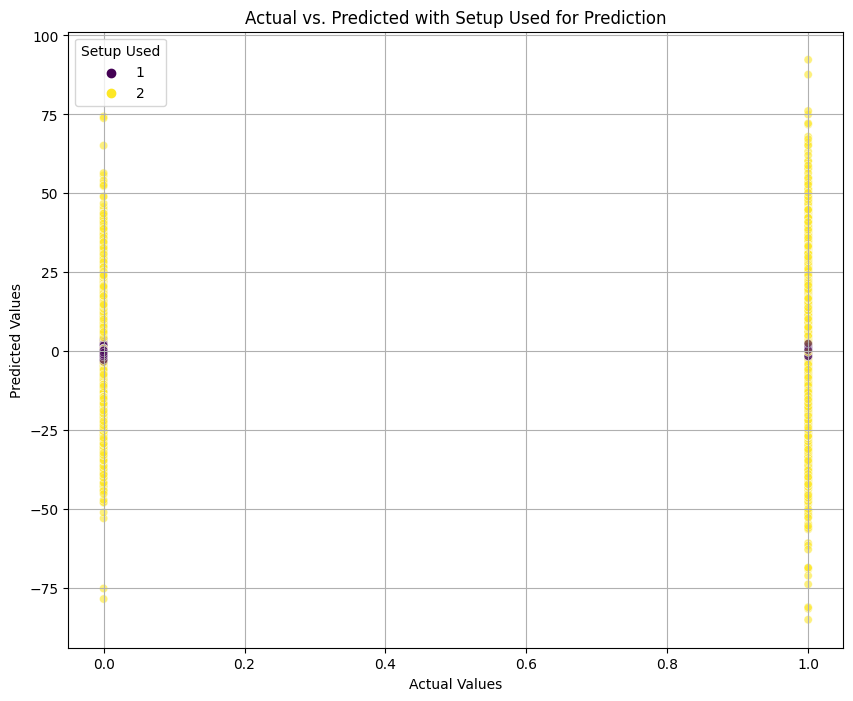

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with the actual and predicted values, and the setup used
results_df = pd.DataFrame({
    'Actual': Y_test,
    'Predicted': final_predictions,
    'SetupUsed': setups_used
})

# Plotting using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=results_df, x='Actual', y='Predicted', hue='SetupUsed', palette='viridis', alpha=0.6)

plt.title('Actual vs. Predicted with Setup Used for Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend(title='Setup Used')
plt.grid(True)
plt.show()